# Supervised Learning

Up until this point, we've explored raw image representations, histogram representations, transfer learning, and unsupervised learning. Today, we'll dive into the world of supervised learning.

Supervised learning is the process of training a machine learning system with data (X) that has corresponding targets (y). Recall that linear regression on an X-Y scatter plot is the simplest example of supervised learning. In that case, you have some data X that you try to fit a linear model (or polynomial, exponential, etc.) such that you minimize the sum of squared error (distance) between `Y` and `f(x)`.

Here, we'll revisit our familiar NEU Surface Defect Dataset and try supervised learning with a support vector machine (SVM).

In [1]:
# first let's import some things
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import sys
sys.path.insert(0, '..')
from helper import visualize as vis

import pickle

In [ ]:
DF_PATH = os.path.join('..', 'data', 'df_histeq_and_cnn.pickle')
df = pd.read_pickle(DF_PATH)
df.head()

## What's in our dataframe?
Over the last week, we've built this dataframe that connects the image paths to the images, their histograms, histogram-equalized images, the equalized histograms, and the outputs from the first fully connected layer of VGG16. All of these (minus the file paths) are suitable entries for our `X` data and the column `label_x` will be our `y` in classifier system.

In [ ]:
# first let's shuffle our data
df = shuffle(df, random_state=21213)



In [ ]:
# here I'm encoding the labels into numeric form.
le = LabelEncoder()
le.fit(df['label_x'])
label_y = le.transform(df['label_x'])

In [ ]:
print(df['label_x'].unique())
print(le.transform(df['label_x'].unique()))

In [6]:
# Confirm the ordering... we'll come back this when we visualize
print(le.transform(['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc']))

[0 1 2 3 4 5]


In [7]:
# now let's split our data into a training set and a testing set
# it's worth noting that train_test_split has a default parameter to shuffle the data
# so the above code block could be eliminated
# I just wanted to make a point

X_train, X_test, y_train, y_test = train_test_split(df['vgg16_fc1_feature'], 
                                                    label_y,
                                                    test_size=0.3333,
                                                    random_state=14,
                                                    shuffle=False)

In [8]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_train shape: (1200,)
y_train shape: (1200,)
X_test shape: (600,)
y_test shape: (600,)


In [9]:
# note the structure of the data
X_train.to_numpy()

array([array([ 1.0185869 ,  0.06011038,  0.22634305, ...,  0.18460469,
        1.4702579 , -0.46908528], dtype=float32),
       array([ 1.2929233 , -0.03082836,  0.411806  , ..., -0.06645252,
        1.0495225 , -0.5031962 ], dtype=float32),
       array([ 0.6498237 ,  0.6160838 ,  0.459576  , ..., -0.7979248 ,
        0.30591413,  0.2301296 ], dtype=float32),
       ...,
       array([ 0.64223605,  1.0820098 ,  0.01241214, ..., -0.84425676,
        0.19838576,  0.43085635], dtype=float32),
       array([ 0.7845365 , -0.68064046,  0.3180769 , ..., -0.4211093 ,
        0.55167866, -0.38107046], dtype=float32),
       array([-0.12065254,  1.4554516 ,  0.7259005 , ...,  0.8255934 ,
        0.9566213 , -0.06803837], dtype=float32)], dtype=object)

In [10]:
print(X_train.to_numpy()[0].shape)

(4096,)


In [11]:
clf = SVC(kernel='rbf', gamma='auto', random_state=4)
clf.fit(X_train.to_numpy(), y_train)

ValueError: setting an array element with a sequence.

Oh no! It looks like there's a warning message about our data structure. That's okay. We kind of thought something was off. We can fix that with a couple of one-liners. `X_train` and `X_test` are both arrays of arrays, but there's an easy fix to transform them each into a 2-D array. First we'll convert the array to a list, then that list will be re-transformed to a NumPy array, which will automatically shape the array into the form that we want.

In [12]:
X_train = np.array(list(X_train))
X_test = np.array(list(X_test))
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))

X_train shape: (1200, 4096)
X_test shape: (600, 4096)


In [13]:
%%time
clf = SVC(kernel='rbf', gamma='auto', random_state=4)
clf.fit(X_train, y_train)

CPU times: user 1.51 s, sys: 33.7 ms, total: 1.54 s
Wall time: 1.63 s


SVC(gamma='auto', random_state=4)

In [14]:
clf.score(X_test, y_test)

0.9916666666666667

It looks like our classifier obtains nearly perfect performance! Yay! However, as you venture further into your career, you'll become increasingly skeptical of results like this--especially when they come so easily!

Text(0.5, 1.0, 'SVM Confusion Matrix')

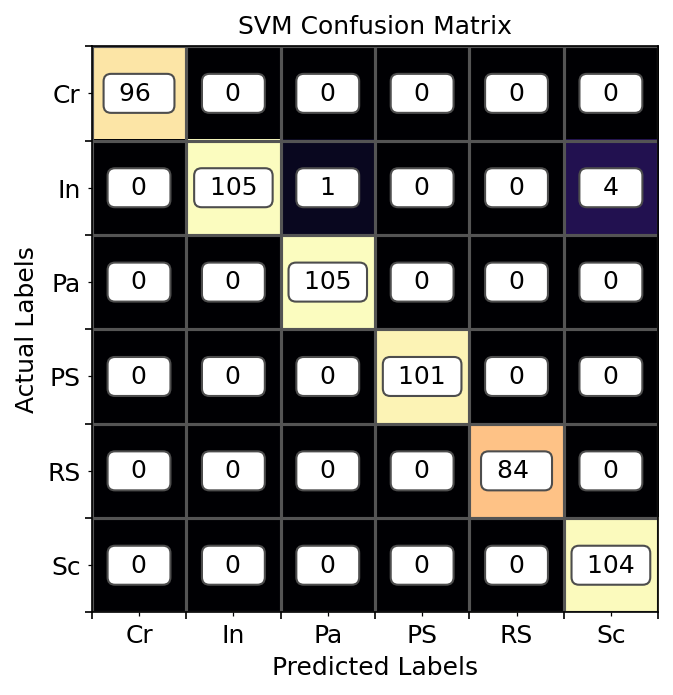

In [15]:
cm = confusion_matrix(clf.predict(X_test), y_test)
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
vis.pretty_cm(cm, ax0=ax)
ax.set_title('SVM Confusion Matrix')


In [16]:
# It actaully seems like Pa and PS are flipped here
for l in ['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc']:
    print(l, le.transform([l]))

Cr [0]
In [1]
PS [2]
Pa [3]
RS [4]
Sc [5]


Text(0.5, 1.0, 'SVM Confusion Matrix')

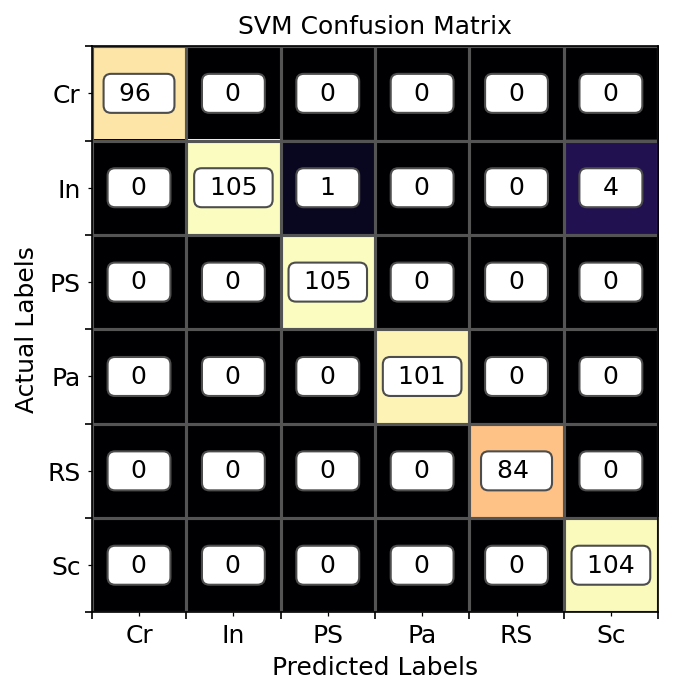

In [17]:
cm = confusion_matrix(clf.predict(X_test), y_test)
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
vis.pretty_cm(cm, ax0=ax, labelnames=['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc'])
ax.set_title('SVM Confusion Matrix')

# K-Fold Cross Validation
We can increase our confidence in the support vector machine by applying a technique called K-Fold cross validation. To this point, we've only trained a classifier once and found that it had pretty good performance. But what if we got lucky? How do we eliminate sheer dumb luck as an explanation?

Cross validation is the process of trying various train/test splits so we can study the variance in classifier performance across various training sets. In this case, I propose we leave our `X_test` and `y_test` data alone. Instead, we'll perform various splits on the remaining `X_train` and `y_train` data.

The K in K-Fold Cross Validation refers to the number of times that we'll split the data. In the case of 5-Fold cross validation, we'll split the data into 5 equal chunks. We can save the first chunk as testing data, and train on the remaining four chunks. Then we'll start over, but this time hold out the second chunk for testing while training on the remaining four. We'll repeat this for a total of five times such that each chunk is selected once to be the testing data after being trained on the other data. As I mentioned before, I want to keep the actual testing data completely hidden, so from here on I'll refer to this interim testing data as *validation* data.

In [18]:
kf = KFold(n_splits=10, random_state=42, shuffle=True)
X = X_train
y = y_train

kf_info = {}

In [19]:
for split, (train_index, val_index) in enumerate(kf.split(X_train)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val  = y[train_index], y[val_index]
    
    clf = SVC(kernel='rbf', gamma='auto')
    clf.fit(X_train, y_train)
    
    kf_info[split] = {"Train Indices": train_index,
                      "Val Indices": val_index,
                      "Train Report": classification_report(clf.predict(X_train), y_train),
                      "Val Report": classification_report(clf.predict(X_val), y_val)}

In [20]:
for k in range(len(kf_info)):
    print("Fold Number = ", k)
    print("Train Report\n", kf_info[0]["Train Report"])
    print("Validation Report\n", kf_info[0]["Val Report"])
    print("------------------------------------------------------")

Fold Number =  0
Train Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       188
           1       1.00      0.99      1.00       173
           2       1.00      1.00      1.00       176
           3       1.00      1.00      1.00       181
           4       1.00      1.00      1.00       190
           5       0.99      1.00      1.00       172

    accuracy                           1.00      1080
   macro avg       1.00      1.00      1.00      1080
weighted avg       1.00      1.00      1.00      1080

Validation Report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.92      0.96        25
           2       0.94      1.00      0.97        17
           3       1.00      1.00      1.00        18
           4       1.00      1.00      1.00        26
           5       0.95      1.00      0.97        18

    accuracy               

It looks like the performance doesn't really change for each of the splits. This is great news! It demonstrates that our SVM might actually be performing well as a classifier. Of course, we expect that it would. Even K-Means seems to group the data pretty strongly. So, what if we wanted to make a model and export it?

Let's say we think fold 3 in our 10-fold cross validation gave us the best results, and we wanted to build a model based on that. Thankfully, we kept a log of the indices from each fold, so we can go back and fetch them again. All we need to do is re-train a classifier using those indices. 

Text(0.5, 1.0, 'SVM Confusion Matrix')

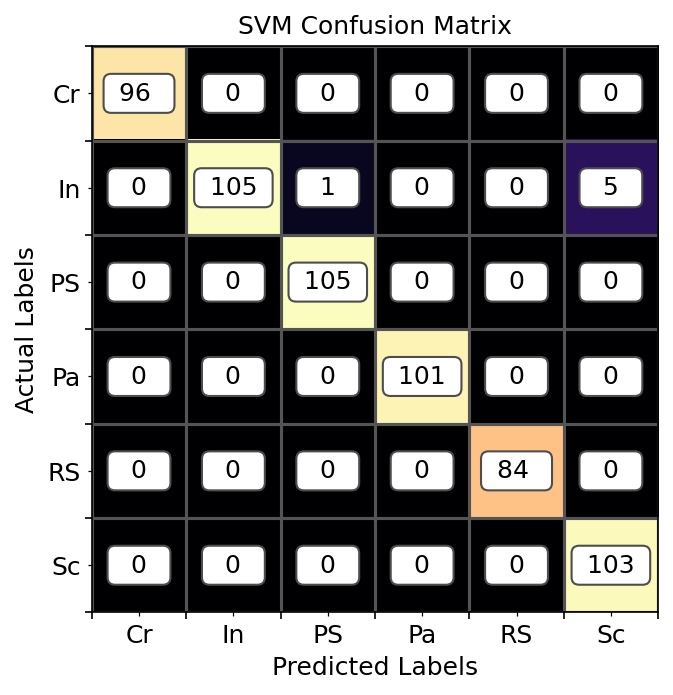

In [21]:
train_index = kf_info[3]["Train Indices"]

X_train, y_train = X[train_index], y[train_index]

clf = SVC(kernel='rbf', gamma='auto')
clf.fit(X_train, y_train)

y_hat = clf.predict(X_test)
cm = confusion_matrix(y_hat, y_test)
fig, ax = plt.subplots(1,1, figsize=(5,5), dpi=150)
vis.pretty_cm(cm, ax0=ax, labelnames=['Cr', 'In', 'PS', 'Pa', 'RS', 'Sc'])
ax.set_title('SVM Confusion Matrix')

In [22]:
# Save the classifier using Pickle
CLF_PATH = os.path.join('..', 'models', 'SVM_classifier.pkl')

with open(CLF_PATH, 'wb') as f:
    pickle.dump(clf, f)

# Load the classifier later as

# CLF_PATH = os.path.join('..', 'models', 'SVM_classifier.pkl')
# with open(CLF_PATH, 'rb') as f:
#     clf = pickle.load(f)

# Summary
We've covered a couple of simple concepts in supervised learning, but I must warn you that there are more pitfalls that you might encounter. You might find yourself dealing with data where your input variables have wildly different ranges and variances. To counter this, you may be interested in using something like `sklearn.preprocessing.StandardScaler()` to standardize features by removing the mean and scaling to unit variance.

In this notebook we only covered one type of supervised learning tool: the support vector machine (SVM). Specifically, we were using a support vector classifier (SVC). SVMs are nice because they are quick to train and they look for linear separations in data. If you recall from our PCA lecture, we learned that the *kernel trick* can be applied to SVMs. And if you look closely at the code we covered in this notebook, you might recognize that we applied the *kernel trick* here. 

## Further Exploration
Now that you've had some time to learn about some of these methods, it's time for a couple of more challenging tasks. Some of these questions are more open-ended than before, so it's up to you to be creative in your interpretation and approach. I've ordered these by what I believe is increasing difficulty.

- What happens if we don't apply the *kernel trick*?
    - How do we change the code above to only look for linear separations?
- What happens if we train on other features we have?
    - You've already explored unsupervised learning on the raw features, histogram features, etc. Now try applying this method to the various features. What do you expect will happen?
- How do you think performance will change by varying the train/val/test splits?
    - Try various splits and show your results.
- The final block of code that prints out classification performance metrics for each split doesn't visualize the method very well.
    - Make your own visualization tool to make a plot (or several plots) that show classification performance.
- There are a handful of misclassifications.
    - Which ones are misclassified?
    - How are they misclassified?
    - Visualize it.
- There's an extension to K-Fold Cross Validation called *Leave-One-Out Cross Validation*.
    - Look it up and implement it into your own project.